In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
statedict = {'PA':'Pennsylvania', 'CT':'Connecticut', 'MA':'Massachusetts', 'NH':'New Hampshire', 'DE':'Delaware',
             'NC':'North Carolina', 'GA':'Georgia', 'NY':'New York', 'NJ': 'New Jersey', 'RI':'Rhode Island',
             'VA':'Virginia', 'MD':'Maryland', 'SC':'South Carolina', 'VT':'Vermont'}

## Preprocessing

In [7]:
CD_table = pd.read_csv('../Results/CD_table.csv', index_col = 0)
CD_table.loc[CD_table[CD_table['Location'].apply(lambda x: len(x.split(", "))==4)].index, 'Location'] = ['New York City West Ward, New York, New York']
CD_table['Occupations'] = CD_table['Occupations'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))

In [8]:
def processLocation(loc):
    if len(loc) == 1:
        if loc[0] == 'United States':
            return [np.nan, np.nan, np.nan, 'United States']
        elif loc[0].strip() not in list(statedict.values()):
            return [np.nan, np.nan, np.nan, loc[0]]
        else:
            return [np.nan, np.nan, loc[0], 'United States']
    elif len(loc) == 2:
        if loc[1].strip() not in list(statedict.values()):
            return [np.nan, np.nan, loc[0], loc[1]]
        else:
            return [np.nan, loc[0], loc[1], 'United States']
    else:
        return [loc[0], loc[1], loc[2], 'United States']

In [9]:
CD_table[['town', 'county', 'state', 'country']] = CD_table['Location'].apply(lambda x: processLocation(x.split(", "))).values.tolist()
CD_table['state'] = CD_table['state'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['town'] = CD_table['town'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['county'] = CD_table['county'].apply(lambda x: x.strip() if not pd.isnull(x) else x)
CD_table['country'] = CD_table['country'].apply(lambda x: x.strip() if not pd.isnull(x) else x)

In [10]:
CD_table['6p_Total'] = CD_table['6p_Total'] + CD_table['6p_def_Total']
CD_table.drop(['6p_def_Total', '3p_Total'], axis = 1, inplace = True)

In [11]:
tb = CD_table[['Location','Search Names', '6p_Total', 'count', 'town', 'county', 'state', 'country']]
tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
tb_final = tb.groupby(['town', 'county', 'state','country'])['6p_Total', 'count'].sum().reset_index()

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/3679132665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb['Search Names'] = tb['Search Names'].apply(lambda x: x.replace('\'','').replace('\"','').strip('][').split(', '))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/3679132665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb[['town', 'county', 'state','country']] = tb[['town', 'county', 'state','country']].fillna('')
/var/folders/5s/dvrxt95949x1pm_sjxm85lj000

## Maps

In [12]:
# make folders
for dirs in ['maps', 'maps/statemaps', 'maps/allstates', 'maps/states', 'tables']:
    try:
        os.mkdir("../Results/"+dirs)
    except:
        print("{} folder already exists".format(dirs))

maps folder already exists
maps/statemaps folder already exists
maps/allstates folder already exists
maps/states folder already exists
tables folder already exists


## Plot Counties

In [13]:
# import map shapefile
county_df = gpd.read_file("../../Data/StateShapeFiles/historicalcounties")
county_df.rename(columns = {'NHGISNAM':'county'}, inplace = True)
county_df.rename(columns = {'STATENAM':'state'}, inplace = True)

In [14]:
county_count_tb = tb[['county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['county', 'state','country'])['Search Names'].count().reset_index()
county_count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [15]:
## Create table for graphing means
CD_means = CD_table[['State' not in x and 'treasurer' not in y for x, y, in
                     zip(CD_table['Search Names'], CD_table['Occupations'])]].drop(1)
CD_means = CD_means[CD_means['6p_Total'] != 0]
# some cleaning
map_table_grouped = CD_means[['county', 'state', '6p_Total']].fillna('').groupby(['county', 'state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = map_table_grouped[map_table_grouped['county'] != ""]
map_table_grouped['county'] = map_table_grouped['county'].apply(
    lambda x: 'Prince Georges' if x == 'Prince George\'s' else x)
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Queen Annes' if x == 'Queen Anne\'s' else x)
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
# merge debt data and map data
merged_means = pd.merge(county_df, map_table_grouped, on=['county', 'state'], how='left')

In [16]:
## Create table for graphing sums
map_table = CD_table[['county', 'state', '6p_Total']].fillna('')
# some cleaning
map_table_grouped = map_table.groupby(['county', 'state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = map_table_grouped[map_table_grouped['county'] != ""]
map_table_grouped['county'] = map_table_grouped['county'].apply(
    lambda x: 'Prince Georges' if x == 'Prince George\'s' else x)
map_table_grouped['county'] = map_table_grouped['county'].apply(lambda x: 'Queen Annes' if x == 'Queen Anne\'s' else x)
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
# merge debt data and map data
merged = pd.merge(county_df, map_table_grouped, on=['county', 'state'], how='left')
merged['6p_Total'] = merged['6p_Total'].fillna(0)

In [42]:
def plotState(merged, state, fig, ax, variable = '6p_Total', plot = False):
    if state not in statedict.values():
        print("{} is not a valid state".format(state))
        return

    ax.axis('off')
    # get data for particular state
    state_df = merged[merged['state'] == state]
    #state_df[variable] = state_df[variable].apply(lambda x: np.log10(x+1))
    state_max = state_df[variable].max()
    state_df[state_df['state'] == state].apply(lambda merged: ax.annotate(text=merged['county'], fontsize = 7, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    vmin, vmax = 0.01, state_df[variable].max()
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')
    cmap.set_over('blue')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    if variable == "6p_Total":
        label = 'Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean Debt Coupon Stock ($ per Debtholder)'
    cbar.set_label(label)
    # colormap
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')

    state_df[state_df['state'] == state].plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax = state_max)
    ax.set_title('{} in {}'.format(label, state))
    ax.margins(0)
    dirs = 'maps/statemaps'

    if plot:
        fig.savefig('../Results/{}/{}_map.png'.format(dirs, variable), dpi = 200)

False
False
False
False
False
False
False
False
False
False
False
False
False
True


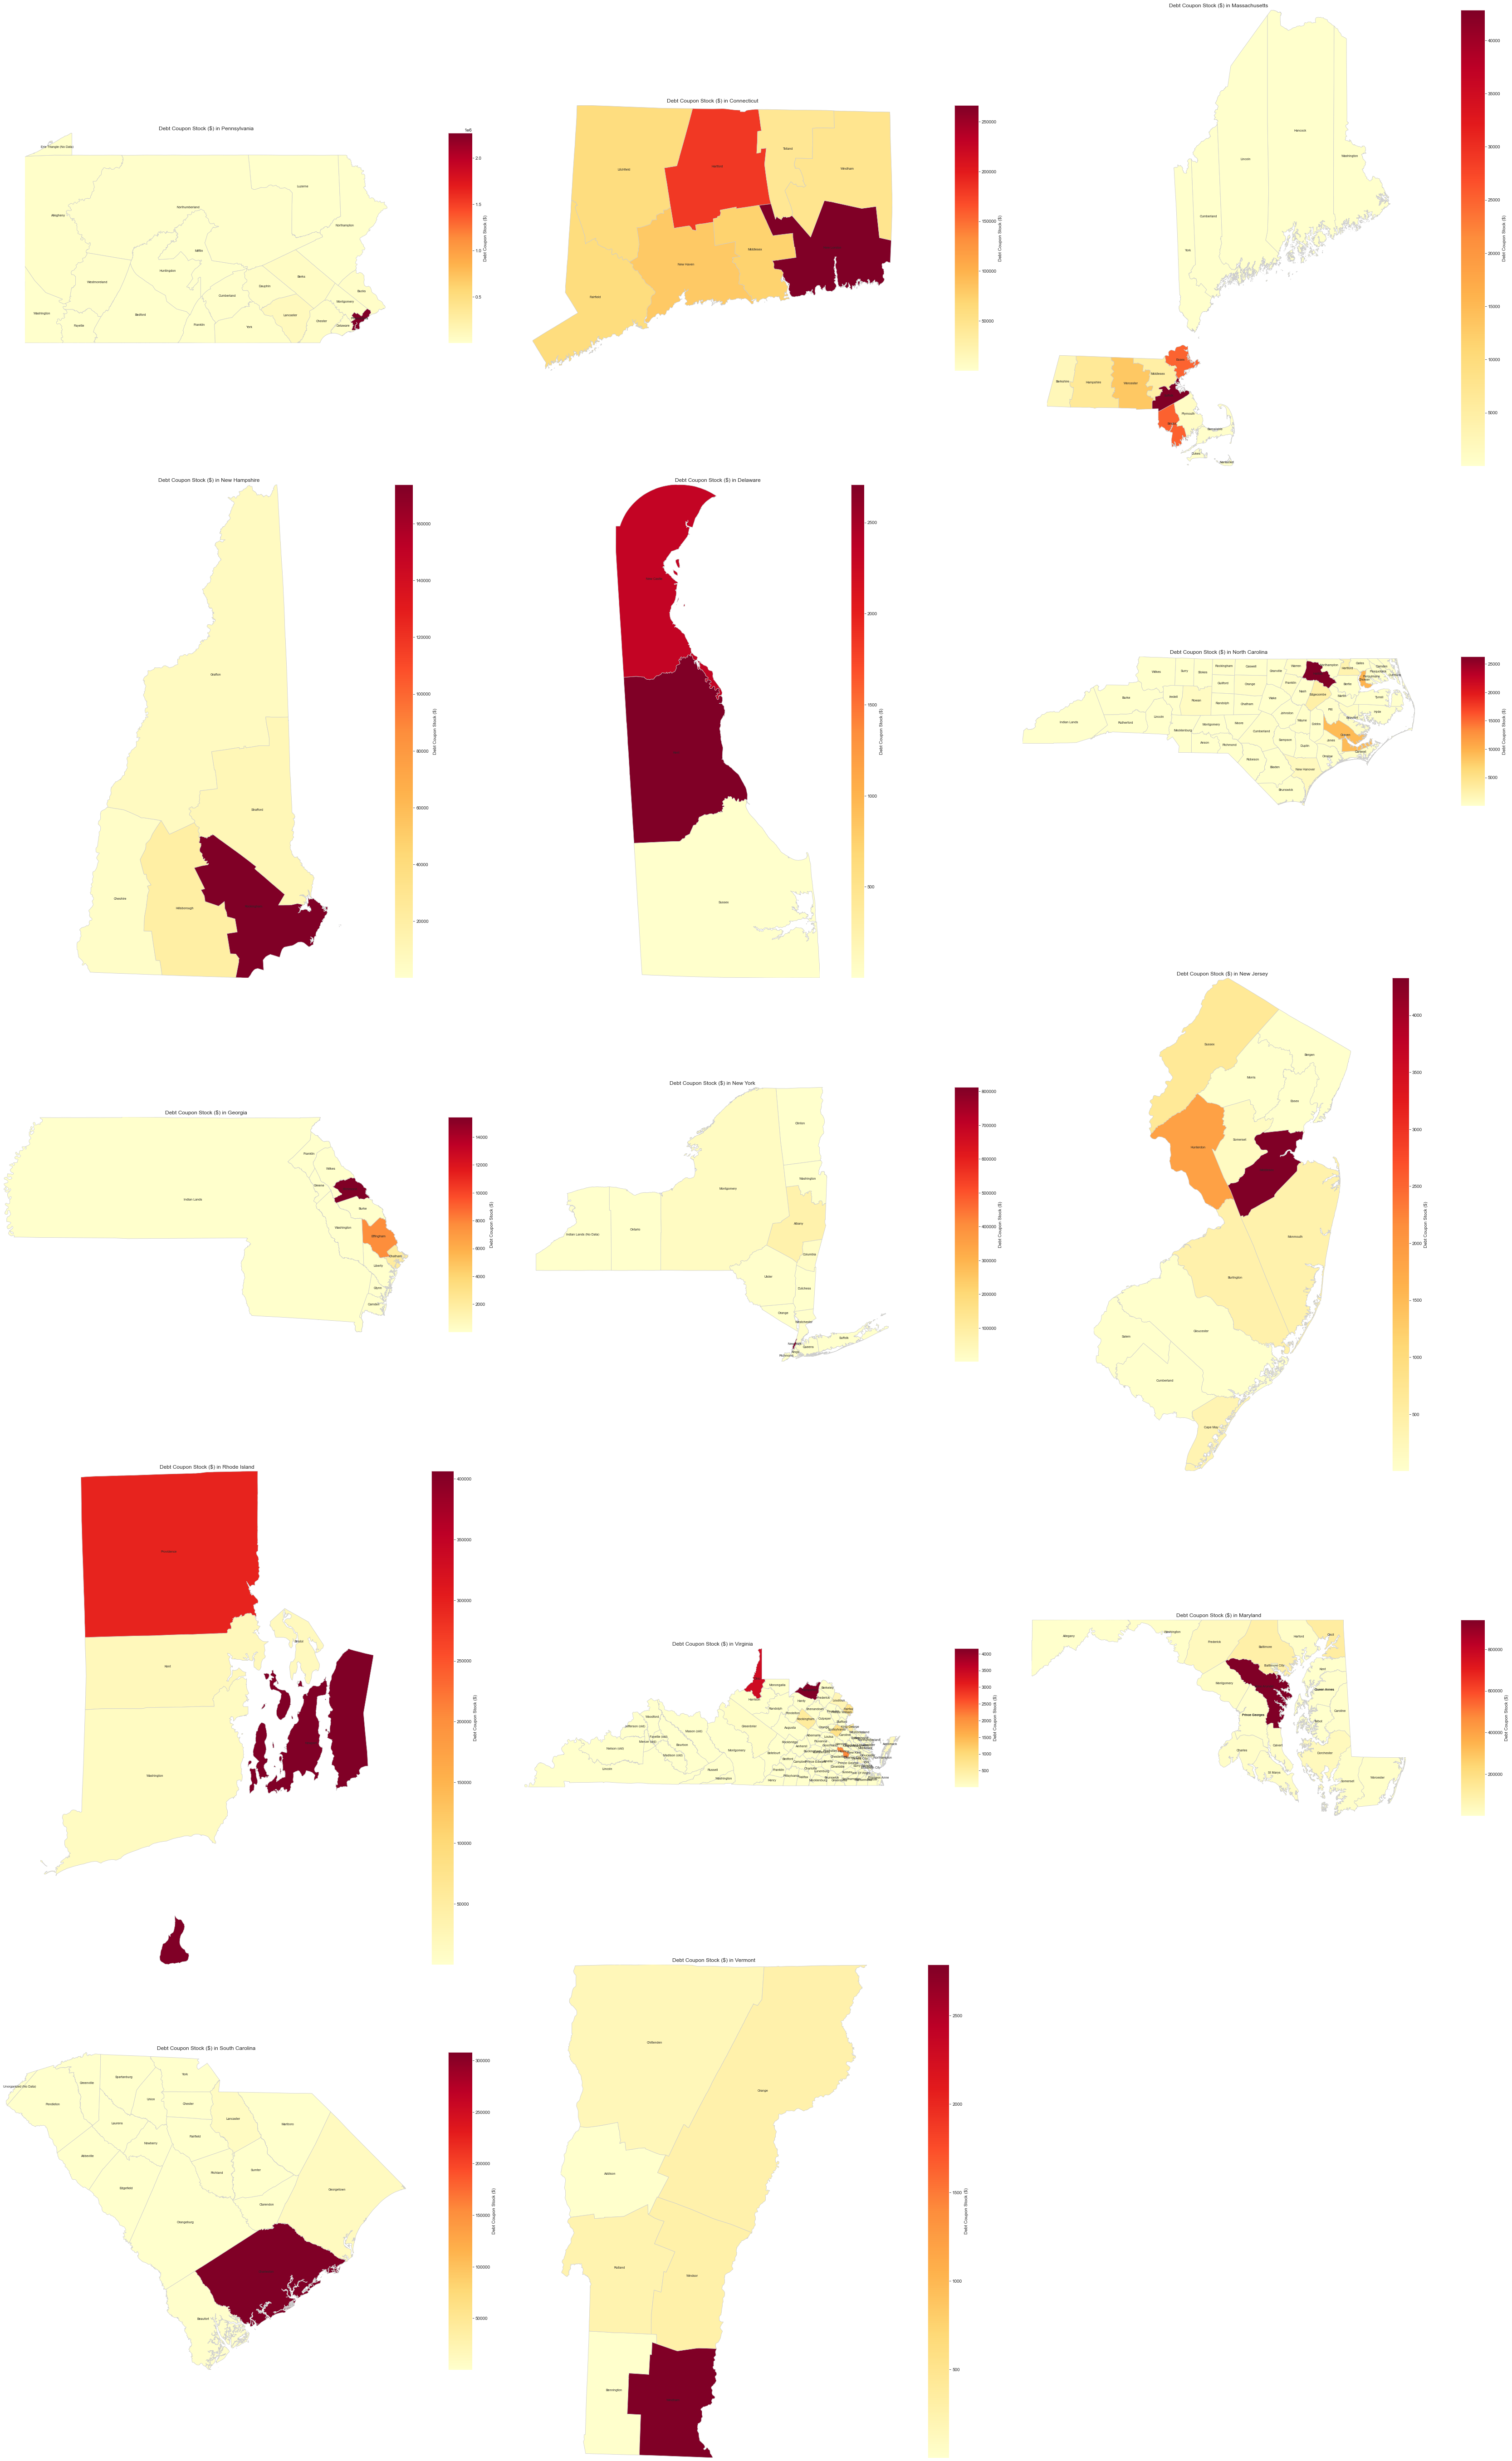

In [43]:
fig, axs = plt.subplots(5, 3, figsize = (60, 100))
plt.subplots_adjust(wspace = 0, hspace = 0)
i = 0
# last one unused
axs[-1, -1].axis('off')
for state in statedict.values():
    p = i == 13
    print(p)
    plotState(merged, state, fig, axs[int(i/3), i%3], plot = p)
    i += 1

In [ ]:
fig, axs = plt.subplots(5, 3, figsize = (60, 100))
plt.subplots_adjust(wspace = 0, hspace = 0)
i = 0
# last one unused
axs[-1, -1].axis('off')
for state in statedict.values():
    p = i == 13
    print(p)
    plotState(merged, state, fig, axs[int(i/3), i%3], plot = p, variable = '6p_Total_avg')
    i += 1

In [30]:
def plotAllStates(merged, variable, log = "log10", plot = True):
    df = merged.copy()
    df[variable] = df[variable].fillna(0)
    fig, ax = plt.subplots(1, figsize=(20, 12))
    df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])
    if variable == '6p_Total':
        annot_df = df.groupby('state').agg({'centroid': min, variable: sum}).reset_index()
    if variable == '6p_Total_avg':
        annot_df = df.groupby('state').agg({'centroid': min, variable: 'mean'}).reset_index()

    annot_df = annot_df.sort_values('centroid')
    if log == "log10":
        df[variable] = df[variable].apply(lambda x: np.log10(x+1))
        annot_df[variable] = annot_df[variable].apply(lambda x: np.log10(x+1))
    if log == "nolog":
        pass
    vmin, vmax = 0.01, df[variable].max()
    print(vmax)
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')
    cmap.set_over('blue')
    if log == "log10":
        thresh = .85*vmax
    if log == "nolog":
        if variable == '6p_Total_avg':
            thresh = vmax/8
        else:
            thresh = vmax/8
    if variable == '6p_Total_avg':
        df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
    else:
        if log == "log10":
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)
        else:
            df[df[variable]>thresh].apply(lambda merged: ax.annotate(text=merged['county'] + " (" +  str(round(merged[variable], 2)) + ", "+ str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 5, xy=merged['geometry'].centroid.coords[0], ha='center'), axis=1)

    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = 'Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean Debt Coupon Stock ($ per Debtholder)'
    cbar.set_label(label)

    df.plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax = vmax)
    ax.margins(0)
    ax.axis('off')
    #ax.set_title("Map of Continental Debt {} Across All States".format(label), fontsize = 20)

    if plot:
        fig.savefig('../Results/maps/allstates/{}_{}_map.png'.format(variable, log), dpi = 400)

# Figure 1

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/4058353539.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


2272866.07


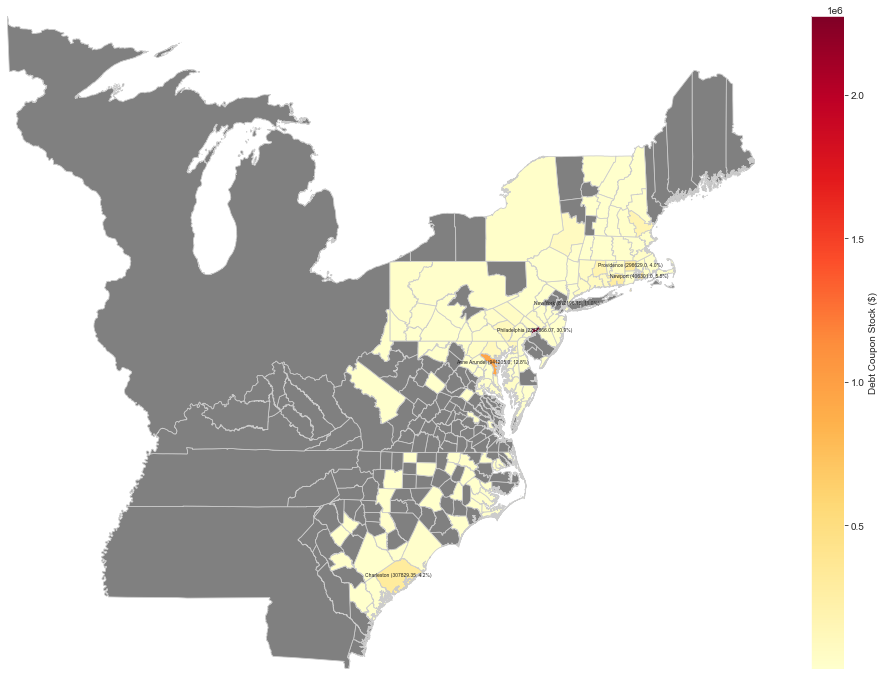

In [31]:
plotAllStates(merged, '6p_Total', log = "nolog")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/4058353539.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


25575.0


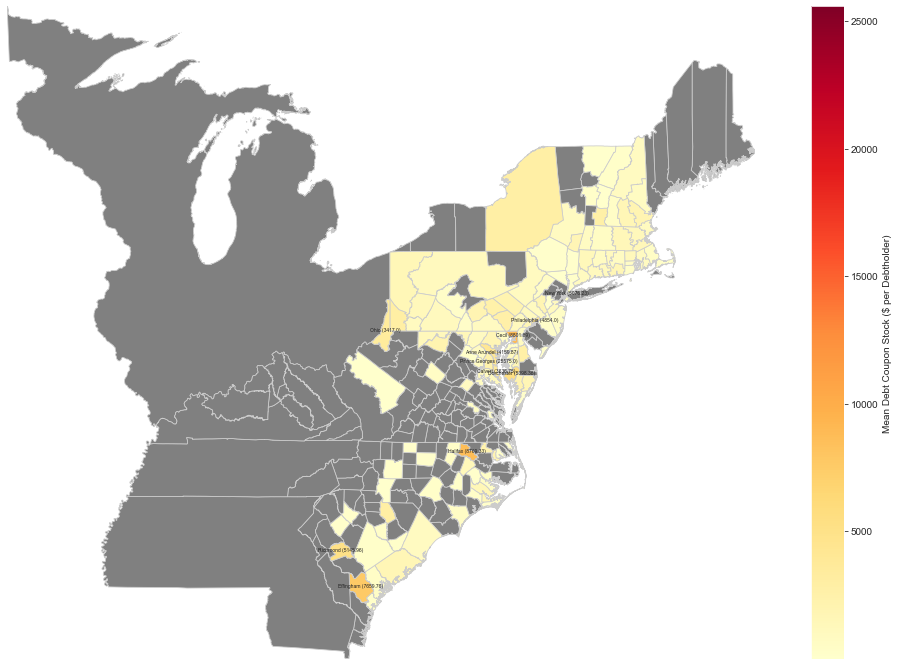

In [32]:
plotAllStates(merged_means, '6p_Total_avg', log = "nolog")

## Plot States

In [33]:
# import map shapefile
state_df = gpd.read_file("../../Data/StateShapeFiles/historicalstates")
state_df['START_DATE'] = state_df['START_DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
state_df['END_DATE'] = state_df['END_DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
state_df = state_df[state_df['CITATION'].apply(lambda x:  'Declaration' in x)]

In [34]:
state_count_tb = tb[['state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['state','country'])['Search Names'].count().reset_index()
state_count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [35]:
# some cleaning
map_table_grouped = CD_means[['state', '6p_Total']].fillna('').groupby(['state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = pd.merge(map_table_grouped, state_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
# merge debt data and map data
merged_means_state = pd.merge(state_df, map_table_grouped, left_on='NAME', right_on = 'state', how='left')

In [36]:
## Create table for graphing sums
map_table = CD_table[['state', '6p_Total']].fillna('')
# some cleaning
map_table_grouped = map_table.groupby(['state']).sum('6p_Total').reset_index()
map_table_grouped = map_table_grouped[map_table_grouped['state'].apply(lambda x: x in statedict.values())]
map_table_grouped = pd.merge(map_table_grouped, county_count_tb)
map_table_grouped['6p_Total_avg'] = map_table_grouped['6p_Total'] / map_table_grouped['# Debtholders']
# merge debt data and map data
merged_state = pd.merge(state_df, map_table_grouped,  left_on='NAME', right_on = 'state', how='left')
merged_state['6p_Total'] = merged_state['6p_Total'].fillna(0)

In [37]:
def plotOnlyStates(merged, variable, log = "log10", plot = True):
    df = merged.copy()
    df[variable] = df[variable].fillna(0)
    fig, ax = plt.subplots(1, figsize=(20, 12))
    df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])

    # manual adjustments
    df['centroid'] = df.apply(lambda x: (x['centroid'][0], x['centroid'][1] + .4) if x['state'] == 'Delaware' else x['centroid'], axis = 1)
    df['centroid'] = df.apply(lambda x: (x['centroid'][0], x['centroid'][1] - .5) if x['state'] == 'Maryland' else x['centroid'], axis = 1)
    df['centroid'] = df.apply(lambda x: (x['centroid'][0] + 4, x['centroid'][1] - 4) if x['state'] == 'Virginia' else x['centroid'], axis = 1)
    df['centroid'] = df.apply(lambda x: (x['centroid'][0], x['centroid'][1] - .3) if x['state'] == 'Connecticut' else x['centroid'], axis = 1)
    df['centroid'] = df.apply(lambda x: (x['centroid'][0], x['centroid'][1] + .1) if x['state'] == 'Rhode Island' else x['centroid'], axis = 1)
    df['centroid'] = df.apply(lambda x: (x['centroid'][0], x['centroid'][1] - 2.5) if x['state'] == 'Massachusetts' else x['centroid'], axis = 1)

    if variable == '6p_Total':
        annot_df = df.groupby('state').agg({'centroid': min, variable: sum}).reset_index()
    if variable == '6p_Total_avg':
        annot_df = df.groupby('state').agg({'centroid': min, variable: 'mean'}).reset_index()

    annot_df = annot_df.sort_values('centroid')

    vmin, vmax = 0.01, df[variable].max()
    print(vmax)
    cmap = plt.get_cmap('YlOrRd').copy()
    cmap.set_under('gray')
    cmap.set_over('blue')

    if variable == '6p_Total_avg':
        df.apply(lambda merged: ax.annotate(text=merged['state'] + " (" +  str(round(merged[variable], 2)) + ")", fontsize = 10, xy=merged['centroid'], ha='center'), axis=1)
    else:
        df.apply(lambda merged: ax.annotate(text=merged['state'] + " (" +  str(round(merged[variable], 2)) + ", "+ str(round(merged[variable]/annot_df[variable].sum()*100, 1))+"%)", fontsize = 10, xy=merged['centroid'], ha='center'), axis=1)

    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    if variable == "6p_Total":
        label = 'Debt Coupon Stock ($)'
    if variable == "6p_Total_avg":
        label = 'Mean Debt Coupon Stock ($ per Debtholder)'
    cbar.set_label(label)

    df.plot(column=variable, cmap= cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax = vmax)
    ax.margins(0)
    ax.axis('off')
    #ax.set_title("Map of Continental Debt {} Across All States".format(label))

    if plot:
        fig.savefig('../Results/maps/states/{}_{}_statesonly_map.png'.format(variable, log), dpi = 400)

# Figure 1

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/3940934779.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


2949771.07


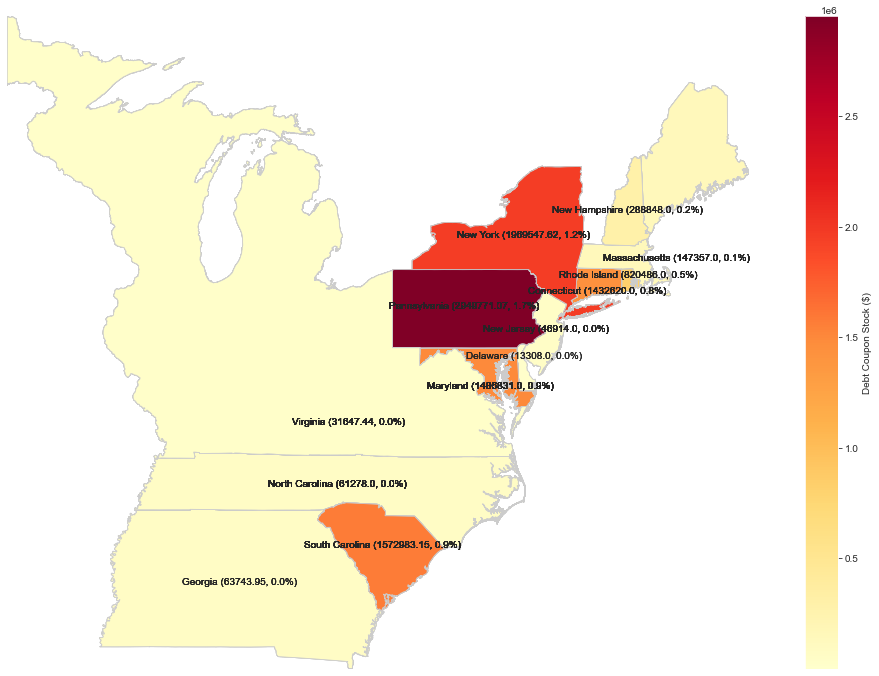

In [38]:
plotOnlyStates(merged_state, '6p_Total', log = "nolog")

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/3940934779.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['centroid'] = df['geometry'].centroid.apply(lambda x: x.coords[0])


3346.853654937571


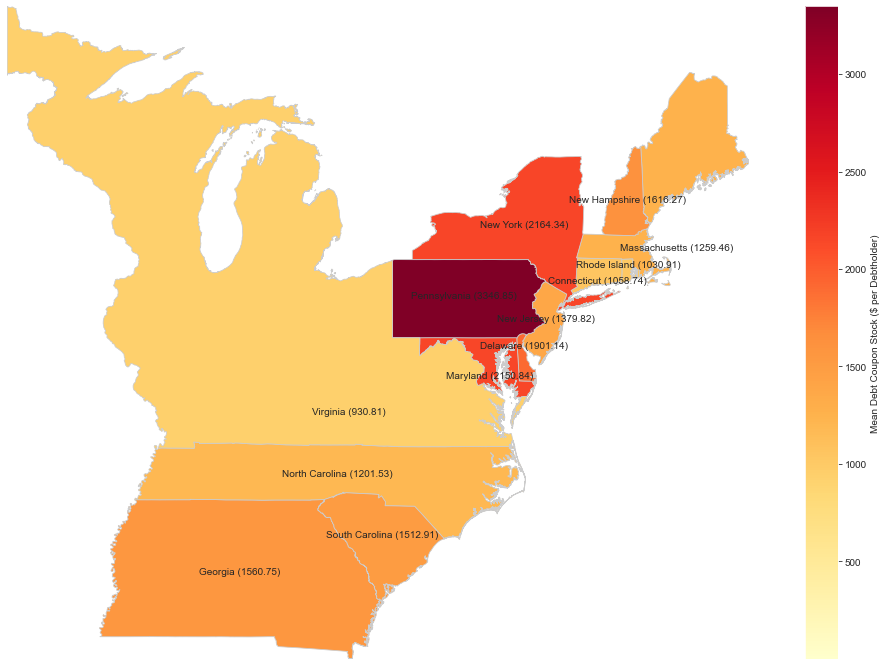

In [39]:
plotOnlyStates(merged_means_state, '6p_Total_avg', log = "nolog")

## Geography Table

In [64]:
count_tb = tb[['town', 'county', 'state','country', 'Search Names']].explode('Search Names').drop_duplicates().groupby(['town', 'county', 'state','country'])['Search Names'].count().reset_index()
count_tb.rename({'Search Names':'# Debtholders'}, axis = 1, inplace = True)

In [65]:
tb_merged = pd.merge(tb_final, count_tb)
tb_merged.rename({'count':'Certificate Count'}, axis = 1, inplace = True)
#tb_merged = tb_merged.replace('', np.nan)

In [66]:
tb_merged['town/county pct'] = np.round(tb_merged['6p_Total'] /
                                             tb_merged.groupby(['state', 'county'])['6p_Total'].transform('sum')*100, 2)
tb_merged['county/state pct'] = np.round(tb_merged.groupby(['state', 'county'])['6p_Total'].transform('sum') /
                                         tb_merged.groupby('state')['6p_Total'].transform('sum')*100, 2)
tb_merged['state/country pct'] = np.round(tb_merged.groupby(['state', 'country'])['6p_Total'].transform('sum') /
                                          tb_merged.groupby('country')['6p_Total'].transform('sum')*100, 2)
tb_merged['country/ovall pct'] = np.round(tb_merged.groupby('country')['6p_Total'].transform('sum') /
                                          tb_merged['6p_Total'].sum()*100, 2)
tb_merged['6p_Total'] = tb_merged['6p_Total'].apply(lambda x: round(x, 2))

In [67]:
tb_merged.drop('6p_Total', axis = 1).sort_values(['country', 'state', 'county', 'town'], ascending = [False, True, True, True]).to_csv('../Results/geography_table.csv')

In [68]:
print(tb_merged.query(' state != "" and country == "United States"')[['state', '6p_Total', 'state/country pct']].groupby('state').agg({'6p_Total': sum,
                                                                                                                                 'state/country pct': 'mean'}).sort_values('state/country pct', ascending = False).to_latex())

\begin{tabular}{lrr}
\toprule
{} &    6p\_Total &  state/country pct \\
state          &             &                    \\
\midrule
Pennsylvania   &  2949771.07 &              27.08 \\
New York       &  1969547.63 &              18.08 \\
South Carolina &  1572983.16 &              14.44 \\
Maryland       &  1486831.00 &              13.65 \\
Connecticut    &  1432620.00 &              13.15 \\
Rhode Island   &   820486.00 &               7.53 \\
New Hampshire  &   288848.00 &               2.65 \\
Massachusetts  &   147357.00 &               1.35 \\
Georgia        &    63743.96 &               0.59 \\
North Carolina &    61278.00 &               0.56 \\
New Jersey     &    46914.00 &               0.43 \\
Virginia       &    31647.44 &               0.29 \\
Delaware       &    13308.00 &               0.12 \\
Vermont        &     6706.00 &               0.06 \\
Maine          &      420.00 &               0.00 \\
\bottomrule
\end{tabular}



/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/536726031.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tb_merged.query(' state != "" and country == "United States"')[['state', '6p_Total', 'state/country pct']].groupby('state').agg({'6p_Total': sum,


## Occupation Table

In [124]:
#basic preprocessing
occ_table = CD_table[['state', 'county', 'Occupations', '6p_Total', 'count']]
occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
occ_table['occ_count'] = 1

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/2028502318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occupations'].astype(str)
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/2028502318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_table['Occ_str'] = occ_table['Occ_str'].apply(lambda x: x.replace("[\'","").replace("\']","").replace("\'",""))
/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/2028502318.py:5

In [147]:
occ_table_grouped = occ_table.groupby(['Occ_str']).agg({'6p_Total':sum,'occ_count':sum, 'count':  sum}).reset_index()
occ_table_grouped.columns = ['Occupations', '6p_Total', 'count', 'cert_count']
occ_table_grouped['Average (6p)'] = (occ_table_grouped['6p_Total'])/occ_table_grouped['count']
occ_table_grouped = occ_table_grouped[occ_table_grouped['Occupations'] != ""]
for col in ['6p_Total', 'count']:
    occ_table_grouped[col+"_pct"] = occ_table_grouped[col]/occ_table_grouped[col].sum()*100
occ_table_grouped['cert_count_avg'] = occ_table_grouped['cert_count']/occ_table_grouped['count']

In [148]:
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['6p_Total_pct'][:5].sum()
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'][:5].sum()/occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'].sum()

0.3993610223642173

In [149]:
# use to table table 3
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x)][['6p_Total']].sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))][['6p_Total']].sum()/100)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))]['count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x))][['6p_Total']].sum()/100)

37.75455846131946 399 6p_Total    1424.02846
dtype: float64
6.463517740545625 15 6p_Total    1110.195352
dtype: float64
23.64322259793036 387 6p_Total    575.778111
dtype: float64


In [150]:
occ_table_grouped.sort_values('6p_Total', ascending = False).to_csv('../Results/Occupation_table.csv')

### Make for each state

In [129]:
for state_fn in statedict.values():
    occ_table_grouped_s = occ_table[occ_table['state'] == state_fn].groupby(['Occ_str']).agg({'6p_Total': sum,'count': sum}).reset_index()
    occ_table_grouped_s.columns = ['Occupations', '6p_Total',  'count']
    occ_table_grouped_s['state'] = state_fn

    occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
    for col in ['6p_Total',  'count']:
        occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[col].sum() * 100
    for col in occ_table_grouped_s.columns[1:]:
        if col != 'state':
            occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
    occ_table_grouped_s.sort_values('6p_Total', ascending = False).to_csv(f'../Results/Occupation_states/{state_fn.replace(" ", "_")}_Occupation_table.csv')

## Analysis

### Summary Statistics

In [75]:
print("Unique Groups: {}".format(CD_table.shape[0]))
print("Ledger rows: {}".format(CD_table['count'].sum()))
print("Town count: {}".format(tb_merged[['town', 'county', 'state']].drop_duplicates().query('town != ""').shape[0]))
print("County count: {}".format(tb_merged[['county', 'state']].drop_duplicates().query('county != ""').shape[0]))
print("% with Occupation: {:.2f}".format(100*np.mean(CD_table['Occupations'].apply(lambda x: x != ['']))))
print("% with Family Size/Slavecount: {:.2f}".format(100-100*np.mean(CD_table['Slavecount'].isna())))
print("Mean, median family size: {:.2f}, {:.2f}".format(CD_table['Family Size'].mean(), CD_table['Family Size'].median()))
print("Mean, median slavecount, % no slaves: {:.2f}, {:.2f}, {:.2f}".format(CD_table['Slavecount'].mean(), CD_table['Slavecount'].median(), np.mean(CD_table.query('not Slavecount.isna()')['Slavecount']==0)))

Unique Groups: 3960
Ledger rows: 6614
Town count: 443
County count: 143
% with Occupation: 39.52
% with Family Size/Slavecount: 47.30
Mean, median family size: 9.62, 8.00
Mean, median slavecount, % no slaves: 2.30, 0.00, 0.77


In [76]:
# table1
tb_merged.query('county == "" and state != "" and country == "United States"')[['state', '6p_Total', 'county/state pct', 'state/country pct']].sort_values('state/country pct')

,state,6p_Total,county/state pct,state/country pct
19,Vermont,2988.00,44.56,0.06
5,Delaware,8287.00,62.27,0.12
20,Virginia,18481.00,58.40,0.29
11,New Jersey,38659.00,82.40,0.43
13,North Carolina,5950.00,9.71,0.56
7,Georgia,38618.98,60.58,0.59
9,Massachusetts,26219.00,17.79,1.35
10,New Hampshire,75894.00,26.27,2.65
15,Rhode Island,70842.00,8.63,7.53
4,Connecticut,622035.00,43.42,13.15


In [77]:
CD_means.query('country == "United States"').groupby('state').agg({'6p_Total':['sum', 'mean']}).sort_values(('6p_Total', 'mean'))

6p_Total              
                         sum          mean
state                                     
Maine           4.200000e+02    420.000000
Vermont         6.706000e+03    958.000000
Virginia        3.164744e+04   1020.885052
Rhode Island    4.762810e+05   1128.627962
Connecticut     7.675880e+05   1143.946349
North Carolina  6.127800e+04   1178.423077
Massachusetts   1.473570e+05   1339.609091
New Jersey      4.691400e+04   1379.823529
South Carolina  3.661242e+05   1544.827648
Georgia         4.370095e+04   1618.553652
New Hampshire   2.165800e+05   1640.757576
Delaware        1.330800e+04   1901.142857
Maryland        8.409770e+05   2342.554308
Pennsylvania    2.948578e+06   3644.719493
New York        1.969548e+06  10258.060537

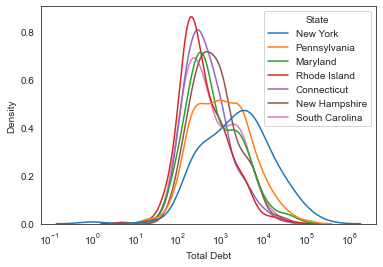

In [93]:
import seaborn as sns
sns.set_style(style='white')
sns.kdeplot(data = CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)[CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)['State'].apply(lambda x: x in ['Rhode Island','Connecticut','Maryland', 'South Carolina', 'New York','Pennsylvania', 'New Hampshire',])].rename({'6p_Total':'Total Debt'}, axis = 1), x = 'Total Debt', hue='State', log_scale = 10, common_norm = False)
plt.savefig('../Results/density_plot.png', dpi = 400)

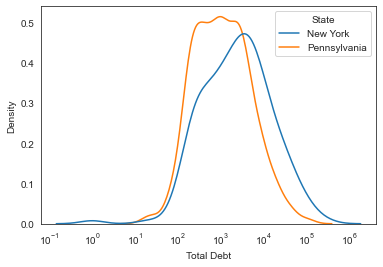

In [94]:
sns.kdeplot(data = CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)[CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)['State'].apply(lambda x: x in [ 'New York','Pennsylvania', ])].rename({'6p_Total':'Total Debt'}, axis = 1), x = 'Total Debt', hue='State', log_scale = 10, common_norm = False)
plt.savefig('../Results/density_plot_big.png', dpi = 400)

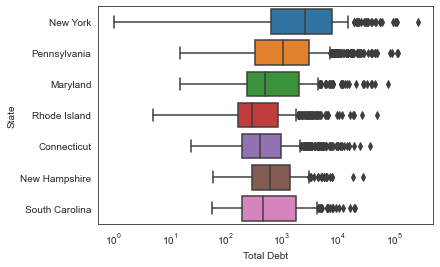

In [118]:
fig, ax = plt.subplots()
ax.set_xscale('log')
sns.boxplot(data = CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)[CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)['State'].apply(lambda x: x in ['Rhode Island','Connecticut','Maryland', 'South Carolina', 'New Hampshire','New York', 'Pennsylvania'])].rename({'6p_Total':'Total Debt'}, axis = 1), x = 'Total Debt', y='State', ax = ax)
plt.savefig('../Results/boxwhisker.png', dpi = 400)

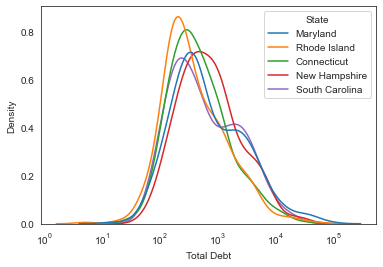

In [95]:
sns.kdeplot(data = CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)[CD_means.query('country == "United States"').rename({'state':'State'}, axis = 1)['State'].apply(lambda x: x in ['Rhode Island','Connecticut','Maryland', 'South Carolina', 'New Hampshire',])].rename({'6p_Total':'Total Debt'}, axis = 1), x = 'Total Debt', hue='State', log_scale = 10, common_norm = False)
plt.savefig('../Results/density_plot_small.png', dpi = 400)

In [151]:
print(occ_table_grouped.sort_values('6p_Total_pct', ascending = False).head(10).round(1).set_index('Occupations').to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   6p\_Total &  count &  cert\_count &  Average (6p) &  6p\_Total\_pct &  count\_pct &  cert\_count\_avg \\
Occupations          &            &        &             &               &               &            &                 \\
\midrule
merchant             &  1301032.3 &    333 &         675 &        3907.0 &          32.6 &       21.3 &             2.0 \\
esquire              &   438026.0 &    212 &         292 &        2066.2 &          11.0 &       13.5 &             1.4 \\
treasurer            &   383248.0 &     21 &          32 &       18249.9 &           9.6 &        1.3 &             1.5 \\
merchant, esquire    &   170750.0 &      5 &          24 &       34150.0 &           4.3 &        0.3 &             4.8 \\
executor             &   124411.5 &     54 &          64 &        2303.9 &           3.1 &        3.5 &             1.2 \\
broker               &   123764.6 &     25 &          72 &        4950.6 &           3.1 &        1.6 &   

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/1823352291.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(occ_table_grouped.sort_values('6p_Total_pct', ascending = False).head(10).round(1).set_index('Occupations').to_latex())


In [158]:
print(occ_table_grouped.sort_values('count', ascending = False).head(10).round(1).set_index('Occupations').to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   6p\_Total &  count &  cert\_count &  Average (6p) &  6p\_Total\_pct &  count\_pct &  cert\_count\_avg \\
Occupations   &            &        &             &               &               &            &                 \\
\midrule
merchant      &  1301032.3 &    333 &         675 &        3907.0 &          32.6 &       21.3 &             2.0 \\
esquire       &   438026.0 &    212 &         292 &        2066.2 &          11.0 &       13.5 &             1.4 \\
farmer        &    82305.0 &    163 &         179 &         504.9 &           2.1 &       10.4 &             1.1 \\
yeoman        &    45926.0 &    104 &         112 &         441.6 &           1.2 &        6.6 &             1.1 \\
widow         &    62620.4 &     76 &          87 &         824.0 &           1.6 &        4.9 &             1.1 \\
executor      &   124411.5 &     54 &          64 &        2303.9 &           3.1 &        3.5 &             1.2 \\
gentleman     &   107240.9 &    

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/2353472203.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(occ_table_grouped.sort_values('count', ascending = False).head(10).round(1).set_index('Occupations').to_latex())


In [162]:
print(occ_table_grouped[occ_table_grouped['count']>5].sort_values('Average (6p)', ascending = False).set_index('Occupations').round(1).head(10).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   6p\_Total &  count &  cert\_count &  Average (6p) &  6p\_Total\_pct &  count\_pct &  cert\_count\_avg \\
Occupations         &            &        &             &               &               &            &                 \\
\midrule
treasurer           &   383248.0 &     21 &          32 &       18249.9 &           9.6 &        1.3 &             1.5 \\
merchant, gentleman &    63203.0 &      6 &          10 &       10533.8 &           1.6 &        0.4 &             1.7 \\
broker              &   123764.6 &     25 &          72 &        4950.6 &           3.1 &        1.6 &             2.9 \\
trustee             &    52374.0 &     12 &          16 &        4364.5 &           1.3 &        0.8 &             1.3 \\
merchant            &  1301032.3 &    333 &         675 &        3907.0 &          32.6 &       21.3 &             2.0 \\
executor            &   124411.5 &     54 &          64 &        2303.9 &           3.1 &        3.5 &          

/var/folders/5s/dvrxt95949x1pm_sjxm85lj00000gn/T/ipykernel_80550/724715858.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(occ_table_grouped[occ_table_grouped['count']>5].sort_values('Average (6p)', ascending = False).set_index('Occupations').round(1).head(10).to_latex())


In [318]:
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['6p_Total_pct'][:10].sum()
occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'][:10].sum()/occ_table_grouped.sort_values('6p_Total_pct', ascending = False)['count'].sum()

0.5578274760383387

In [160]:
# use to table table 3
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)]['count'].sum()
cert = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)]['cert_count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and 'administrator' not in x and 'executor' not in x and 'esquire' not in x and 'gentleman' not in x and 'trustee' not in x and 'gentlewomen' not in x)][['6p_Total']].sum().sum()/100, cert/c)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['count'].sum()
cert = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['cert_count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: ('merchant' in x or 'trader' in x) and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))][['6p_Total']].sum().sum()/100, cert/c)
s = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['6p_Total_pct'].sum()
c = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['count'].sum()
cert = occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))]['cert_count'].sum()
print(s, c, s/c * occ_table_grouped[occ_table_grouped['Occupations'].apply(lambda x: 'merchant' not in x and 'trader' not in x and ('administrator' in x or 'executor' in x or 'esquire' in x or 'gentleman' in x or 'trustee' in x or 'gentlewomen' in x))][['6p_Total']].sum().sum()/100, cert/c)

37.75455846131946 399 1424.0284600290233 1.9649122807017543
6.463517740545625 15 1110.1953521752519 3.1333333333333333
23.64322259793036 387 575.778111176768 1.3901808785529717


2.201923076923077

In [175]:
state_fn = ['Rhode Island', 'New York', 'Pennsylvania', 'New Hampshire', 'New Jersey',
            'Delaware', 'Massachusetts', 'Vermont']
occ_table_grouped_s = occ_table[occ_table['state'].apply(lambda x: x in state_fn)].groupby(['Occ_str']).agg({'6p_Total': sum, 'occ_count':sum, 'count':  sum}).reset_index()
occ_table_grouped_s.columns = ['Occupations', '6p_Total', 'count', 'cert_count']
occ_table_grouped_s['state'] = " ".join(state_fn)
occ_table_grouped_s['cert_count_avg'] = occ_table_grouped_s['cert_count']/occ_table_grouped['count']

occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
for col in ['6p_Total', 'count']:
    occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[occ_table_grouped_s['Occupations']!=""][col].sum() * 100
for col in occ_table_grouped_s.columns[1:]:
    if col != 'state':
        occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
print('merchant: {} %'.format(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum()))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)]['cert_count'].sum()/occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)]['count'].sum())
print('Esquire: {} %'.format(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum()))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)]['cert_count'].sum()/occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)]['count'].sum())

merchant: 42.84 %
2.034632034632035
Esquire: 32.4 %
1.3908794788273615


In [176]:
state_fn = ['Virginia', 'Maryland',  'North Carolina', 'South Carolina', 'Georgia']
occ_table_grouped_s = occ_table[occ_table['state'].apply(lambda x: x in state_fn)].groupby(['Occ_str']).agg({'6p_Total': sum, 'occ_count':sum, 'count':  sum}).reset_index()
occ_table_grouped_s.columns = ['Occupations', '6p_Total', 'count', 'cert_count']
occ_table_grouped_s['state'] = " ".join(state_fn)
occ_table_grouped_s['cert_count_avg'] = occ_table_grouped_s['cert_count']/occ_table_grouped['count']

occ_table_grouped_s['Average (6p)'] = occ_table_grouped_s['6p_Total'] / occ_table_grouped_s['count']
for col in ['6p_Total', 'count']:
    occ_table_grouped_s[col + "_pct"] = occ_table_grouped_s[col] / occ_table_grouped_s[occ_table_grouped_s['Occupations']!=""][col].sum() * 100
for col in occ_table_grouped_s.columns[1:]:
    if col != 'state':
        occ_table_grouped_s[col] = occ_table_grouped_s[col].apply(lambda x: round(x, 2))
print('merchant: {} %'.format(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum()))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)]['cert_count'].sum()/occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'merchant' in x)]['count'].sum())
print('Esquire: {} %'.format(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)].sort_values('6p_Total', ascending = False)['6p_Total_pct'].sum()))
print(occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)]['cert_count'].sum()/occ_table_grouped_s[occ_table_grouped_s['Occupations'].apply(lambda x: 'esquire' in x or 'gentlewoman' in x or 'gentleman' in x or 'executor' in x or 'trustee' in x or 'administrator' in x)]['count'].sum())

merchant: 58.1 %
2.201923076923077
Esquire: 19.94 %
1.5423728813559323
